# Recurrent Neuronal Network (LSTM)

The objective of this job is to predict the answer number 100 for 20.000 students

The model used is a <b> RNN (LSTM) </b>

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv("/Users/user/Desktop/Data Scientis R Python SQL/Desafios/SigmaGeek/Dataset_model.csv")

In [2]:
data.head()

,novo_user_id,city,country,device,device_type,os,platform,region,gp:carrers,gp:college type,...,institute_id,knowledge_area_id,modality_id,nullified,outdated,product_id,publication_year,right_answer,scholarity_id,novo_question_id
0,1,Rio de Janeiro,Brazil,Apple iPhone,Apple iPhone 11 Pro Max,ios 15.4.1,iOS,Rio de Janeiro,"Tribunal, Administrativa",NaN,...,4126.0,13.0,1.0,0.0,0.0,1.0,2022.0,A,2.0,489400
1,1,Rio de Janeiro,Brazil,Apple iPhone,Apple iPhone 11 Pro Max,ios 15.4.1,iOS,Rio de Janeiro,"Tribunal, Administrativa",NaN,...,4126.0,13.0,1.0,0.0,0.0,1.0,2022.0,C,2.0,489399
2,1,Rio de Janeiro,Brazil,Apple iPhone,Apple iPhone 11 Pro Max,ios 15.4.1,iOS,Rio de Janeiro,"Tribunal, Administrativa",NaN,...,4126.0,13.0,1.0,0.0,0.0,1.0,2022.0,D,2.0,489398
3,1,Rio de Janeiro,Brazil,Apple iPhone,Apple iPhone 11 Pro Max,ios 15.4.1,iOS,Rio de Janeiro,"Tribunal, Administrativa",NaN,...,4126.0,13.0,1.0,0.0,0.0,1.0,2022.0,A,2.0,489397
4,1,Rio de Janeiro,Brazil,Apple iPhone,Apple iPhone 11 Pro Max,ios 15.4.1,iOS,Rio de Janeiro,"Tribunal, Administrativa",NaN,...,4126.0,13.0,1.0,0.0,0.0,1.0,2022.0,E,2.0,489396


In [3]:
print(f'The dataset contains {data.shape[1]} columns and {data.shape[0]} samples. This is {data.row.nunique()} questions for {data.novo_user_id.nunique()} students' )

The dataset contains 32 columns and 2000000 samples. This is 100 questions for 20000 students


In [4]:
data.dtypes

novo_user_id                int64
city                       object
country                    object
device                     object
device_type                object
os                         object
platform                   object
region                     object
gp:carrers                 object
gp:college type            object
gp:degree course           object
gp:previous experience     object
gp:school type             object
gp:segment                 object
gp:source_project          object
acertou                     int64
created_at                 object
row                         int64
commented_by_professor    float64
difficulty                float64
discipline_id             float64
examining_board_id        float64
institute_id              float64
knowledge_area_id         float64
modality_id               float64
nullified                 float64
outdated                  float64
product_id                float64
publication_year          float64
right_answer  

In [5]:
data.isna().sum()

novo_user_id                    0
city                       142400
country                     13200
device                      71600
device_type                163200
os                          13200
platform                    13200
region                      13700
gp:carrers                 116900
gp:college type           1997500
gp:degree course          1997500
gp:previous experience    1052200
gp:school type            1997500
gp:segment                  35200
gp:source_project           38000
acertou                         0
created_at                      0
row                             0
commented_by_professor        178
difficulty                   2629
discipline_id                 178
examining_board_id            182
institute_id                  182
knowledge_area_id             178
modality_id                   178
nullified                     178
outdated                      178
product_id                    178
publication_year              187
right_answer  

There are multiple unique values in most of the columns, so will be hard to use one hot encoding to work with them:

In [6]:
data.nunique()

novo_user_id                20000
city                         1799
country                        18
device                        217
device_type                   394
os                            231
platform                        3
region                         50
gp:carrers                   1451
gp:college type                 2
gp:degree course               16
gp:previous experience          4
gp:school type                  6
gp:segment                      4
gp:source_project               2
acertou                         2
created_at                1956537
row                           100
commented_by_professor          2
difficulty                      5
discipline_id                 225
examining_board_id            580
institute_id                 3099
knowledge_area_id              94
modality_id                     2
nullified                       2
outdated                        2
product_id                      5
publication_year               23
right_answer  

The dataset "subjets_questions" contains the subject id for each question. Each question could have multiples subjects. This information will be added to the main dataset.



In [7]:
subjets_questions = pd.read_csv("/Users/user/Desktop/Data Scientis R Python SQL/Desafios/SigmaGeek/subjects_questions.csv")
subjets_questions.head()


,subject_id,novo_question_id
0,14655.0,15
1,19271.0,15
2,14655.0,16
3,19271.0,16
4,14655.0,17


In [8]:
#Delete the null samples
subjets_questions = subjets_questions[~subjets_questions.subject_id.isnull()]

#Delete created_at column
data = data.drop(['created_at','row'], axis = 1)

#Save the unique subject id values into "subject_id" array
subject_id = subjets_questions.subject_id.unique()

#"rates" array will contain the pass rate for each subject id
rates = []

for i in subject_id:
    
    question_id = subjets_questions.novo_question_id[subjets_questions.subject_id == i]

    acertou = data.acertou.values

    right = acertou[data.novo_question_id.isin(question_id)]
    
    rates.append( [right.sum()/len(right),i,len(right)])

rates = pd.DataFrame(rates,columns = ['rate','subject_id','number_cases'])
    
#Join the pass rates and "subjets_questions" dataset  into an dataframe called "subjets_questions_rates"
subjets_questions_rates = subjets_questions.merge(rates, how = 'left', on = 'subject_id')
subjets_questions_rates = subjets_questions_rates[subjets_questions_rates.number_cases != 0]


###define a weighted sum operation
def weighted_sum(values,weights):
    
    w_sum = (values*weights).sum()/weights.sum()
    return(w_sum)

###

#Save unique novo_question_id values into "novo_question_id" dataframe
novo_question_id = subjets_questions_rates.novo_question_id.unique()

#Pass it as an array
novo_question_id_array  = np.asanyarray(subjets_questions_rates.novo_question_id)

#Pass "subjets_questions_rates" as an array
rate_array  = np.asanyarray(subjets_questions_rates.rate)

#number_cases_array is the wheigth for each rate
number_cases_array  = np.asanyarray(subjets_questions_rates.number_cases)

#question_rates contains the weighted_rate for each question_id
question_rates = []

for i in novo_question_id:
    
    slice_ = novo_question_id_array == i
    values = rate_array[slice_]
    weights = number_cases_array[slice_]

    question_rates.append([i,weighted_sum(values,weights)])
                 
question_rates = pd.DataFrame(question_rates,columns = ['novo_question_id','targ_prop_question_id'])

#Merge the rates and data
data = data.merge(question_rates, how = 'left', on = 'novo_question_id')

data['targ_prop_question_id'] = data['targ_prop_question_id'].fillna(data['targ_prop_question_id'].mean())

In [9]:
#Convert string columns as an object
data = data.convert_dtypes()
data[data.columns[data.dtypes == 'string']]=data[data.columns[data.dtypes == 'string']].astype('object')

### target_cum_mean

Is the cumulate passing average at each time step for each student

In [10]:
data.acertou[0*100:0*100+99].cumsum()/np.arange(1,100)

0          0.0
1          0.0
2     0.333333
3         0.25
4          0.4
        ...   
94    0.568421
95      0.5625
96    0.556701
97     0.55102
98    0.545455
Name: acertou, Length: 99, dtype: object

In [11]:
target_cum_mean = []

for i in range(0,20000):
    
    cum_mean = data.acertou[i*100:i*100+99].cumsum()/np.arange(1,100)
    target_cum_mean.append([0]+list(cum_mean))
    
target_cum_mean = np.array(target_cum_mean).reshape(-1,1).ravel()

#Adding of the cumulate passing average to the dataset
data['target_cum_mean'] = target_cum_mean

### mean_target

Is the passing average for each student

In [12]:
mean_target=  pd.concat([data,pd.Series(np.repeat(range(20000),99),name = 'student')], axis = 1).groupby('student').mean()['acertou'].values

#Adding of the passing average to the dataset
data['mean_target'] = np.repeat(mean_target,100)



### lag

Is the probability of failing given n time steps for each student

In [13]:
lag = []

for student in range(0,20000):
    target_student = data.acertou[(student*100):99+(student*100)].values
    
    lag.append(0)

    for i in range(1,100):
        j = i
        while target_student[j-1] != 1:
            j = j-1
            if j == 0:
                break
        
        lag.append(i-j+1)

lag = np.array(lag)

data['lag'] = lag

In [14]:
lag_student_number = pd.concat([pd.Series(data.acertou, name = 'lag_student_av', index = data.index),
                              data.novo_user_id,
                              pd.Series(lag, name='lag', index = data.index)],
                             axis = 1).groupby(['novo_user_id','lag']).sum()

student_pass = pd.concat([pd.Series(data.acertou, name = 'lag_student_av', index = data.index),
                          data.novo_user_id],
                         axis = 1).groupby('novo_user_id').sum()

lag_student_rate = lag_student_number / student_pass

data = data.join(lag_student_rate, on =['novo_user_id', 'lag'])

data['lag_student_av'] = data['lag_student_av'].fillna(data['lag_student_av'].mean())

In [15]:

data = data[data.columns[~((data.isna().sum()/data.shape[0]) > 0.1)]]

### Classes

Classes are created to transform both training and testing dataset 

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

# Remove_columns_na: Remove columns that contains more than 15% of missing values
class Remove_columns_na(BaseEstimator,TransformerMixin):

    def __init__(self):
        return None
    
    def fit(self,X,y = None):
        
        self.col_to_drop = X.columns[X.isna().sum()/len(X)>0.15]
        
        return self
        
        
    def transform(self,X,y = None):
        
        X = X.drop(self.col_to_drop,axis = 1)
        
        return X
    
    
 ###Frequency: Categorical columns are replaced as the frequency rate of their values. The frequency rate are between 0 and 1
class Frequency(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        return None
        
    def fit(self,X,y = None):

        return self
        
    def transform(self, X, y=None):
        
        self.features = [c for c in X.columns[((X.dtypes == 'object') | (X.dtypes == 'Int64')) & (X.columns != 'acertou')& (X.columns != 'novo_user_id')]]

        for i in self.features:
            
            freq = X.groupby(i).size()/X[i].notnull().sum()
            max_ = (X.groupby(i).size()/X[i].notnull().sum()).max()
            
            X['freq_{k}'.format(k=i)] = X[i].map(freq).fillna(max_)
                        
        return X
    
    
### Target_Prop: Is the passing rate for each of each category in categorical columns
class Pass_Rate(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        return None
        
    def fit(self,X,y = None):
        
        
        return self
        
    def transform(self, X, y=None):
        
        self.features = [c for c in X.columns[((X.dtypes == 'object') | (X.dtypes == 'Int64')) & (X.columns != 'acertou')]]
        
        pass_prop = pd.DataFrame(dtype=float)
    
        for i in self.features:

            prop = pd.Series(X.groupby(i)['acertou'].sum()/X.groupby(i).count()['acertou'])

            X['pass_rate_{k}'.format(k=i)] = X[i].map(prop).fillna(prop.max())

            
        return X

### Weighted_Average: Multiply the frequency and pass rate for each class in each column
class Weighted_Average(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        return None
        
    def fit(self,X,y = None):
        self.features = [c for c in X.columns[((X.dtypes == 'object') | (X.dtypes == 'Int64')) & (X.columns != 'acertou') & (X.columns != 'novo_user_id')]]
                
        return self
        
    def transform(self, X, y=None):

        for i in self.features:

            X['weighted_average_{k}'.format(k=i)] = X['pass_rate_{k}'.format(k=i)] * X['freq_{k}'.format(k=i)]
                
        return X

    
 ###Grouping: The categorical columns are re-categorized into 4 groups with a similar pass rate, where group_a groups the categories with the highest pass rate and group_d the least.
            # It's applied for each categorical column
class Grouping(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        return None
        
    def fit(self,X,y = None):
        self.features = [c for c in X.columns[((X.dtypes == 'object') | (X.dtypes == 'Int64')) & (X.columns != 'acertou')& (X.columns != 'novo_user_id')]]
        
        self.gruops_acum = pd.Series(dtype = float)
        self.mask_acum = pd.Series(dtype = str)
        
        for i in self.features:
            
            mean_groups = X.groupby(i).mean()['acertou'].sort_values()            
                
            if len(mean_groups) == 2:
                
                gruops = pd.Series(['{k}_group_a'.format(k=i),'{k}_group_b'.format(k=i)], index = mean_groups.index)
            else:
                
                gruops = pd.Series(np.where(mean_groups<=0.45,'{k}_group_a'.format(k=i),np.where(mean_groups.between(0.45,0.65), '{k}_group_b'.format(k=i),np.where(mean_groups.between(0.65,0.85),'{k}_group_c'.format(k=i), '{k}_group_d'.format(k=i))))) 

                gruops.index = mean_groups.index

            self.gruops_acum = pd.concat([self.gruops_acum,gruops])
            
            mask = pd.Series((np.repeat(i,len(gruops))))
            self.mask_acum = pd.concat([self.mask_acum,mask])
        
        return self
        
    def transform(self, X, y=None):

        for i in self.features:
            
            column = X[i].map(self.gruops_acum[list(self.mask_acum == i)])
            X = pd.concat([X,pd.get_dummies(column)], axis = 1)
            
        return X
    
###   Drop_Columns: Object or id columns are removed 
class Drop_Columns(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        return None
        
    def fit(self,X,y = None):
        self.features = [c for c in X.columns[(X.dtypes == 'object') | (X.dtypes == 'Int64')]]
        
        return self
        
    def transform(self, X, y=None):

        X = X.drop(self.features,axis = 1)
                
        return X

####  Scaler: Min-Max scaler  
class Scaler(BaseEstimator, TransformerMixin):
        
    def fit(self,X,y = None):
        
        self.max_col = []
        self.min_col = []
        self.max_col.append(X[X.columns[X.dtypes != 'object']].max(axis=0))
        self.min_col.append(X[X.columns[X.dtypes != 'object']].min(axis=0))
        
        return self
        
    def transform(self, X, y=None):
        
        
        j = 0
        for c in X.columns[X.dtypes !='object']:
            max_ = self.max_col[0][c]
            min_ = self.min_col[0][c]
            
            X[c] = X[c].apply(lambda x :(x-min_)/(max_-min_))
            j = j+1
            
        return X
    

In [17]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    ('remove_columns', Remove_columns_na()),
    ('frequency' , Frequency()),
    ('pass_rate' , Pass_Rate()),
    ('weighted_average' , Weighted_Average()),
    ('grouping' ,Grouping()),
    ('drop_col' , Drop_Columns()),
    ('scaler' , Scaler())
])

#Transform the data through the pipeline
data_preprocessed = pipe.fit(data).transform(data)

In [18]:
print(f'The dataframe contains now {len(data_preprocessed.columns)} columns')

The dataframe contains now 148 columns


In [19]:
print(f'Number of numerical columns after the processing: {(data_preprocessed.dtypes == "float64").sum()}')

Number of numerical columns after the processing: 148


In [20]:
print(f'Number of missing values after the processing: {data_preprocessed.isna().sum().sum()}')

Number of missing values after the processing: 0


In [21]:
data_preprocessed.head(5)

,targ_prop_question_id,target_cum_mean,mean_target,lag,lag_student_av,freq_city,freq_country,freq_device,freq_device_type,freq_os,...,publication_year_group_c,right_answer_group_a,right_answer_group_b,right_answer_group_c,scholarity_id_group_b,scholarity_id_group_c,novo_question_id_group_a,novo_question_id_group_b,novo_question_id_group_c,novo_question_id_group_d
0,0.652704,0.000000,0.45679,0.000000,0.000000,0.669856,1.0,0.145678,0.002106,0.018848,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.652704,0.000000,0.45679,0.027027,0.238751,0.669856,1.0,0.145678,0.002106,0.018848,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.652704,0.000000,0.45679,0.040541,0.110193,0.669856,1.0,0.145678,0.002106,0.018848,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.652704,0.333333,0.45679,0.013514,0.569330,0.669856,1.0,0.145678,0.002106,0.018848,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.652704,0.250000,0.45679,0.027027,0.238751,0.669856,1.0,0.145678,0.002106,0.018848,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


### Training and Testing partition

In [22]:
#The testing dataframe is the question number 100 for each student
X_test_preprocessed = data_preprocessed[99::100].copy()

#The testing dataframe is the question 1 to the 99, for each student
X_train_preprocessed = data_preprocessed[~data_preprocessed.index.isin(X_test_preprocessed.index)].copy()

y_test = data.acertou[99::100]
y_train = data.acertou[~data.index.isin(X_test_preprocessed.index)]

### LSTM windows

The model requieres moving sliding windows of n timestep to learn the patterns

In [24]:
#Sliding window generator with 3 timestep. So the samples (t-2, t-1, t) will be used in each window to predict the value of Y at time "n"

#Validation dataframe: The 80% of the data is used as training and 20% as validation. 
#This is, from timestep 1 to 73 is the training and from timestep 74 to 99 is the validation

#sample_weight_seq: 

step_past = 3

def generate_data(X, y, sequence_length = 99, step_past = step_past, step_future = 0, students = 20000):
    
    X = X.to_numpy()
    y = y.to_numpy()

    train_index = np.round((sequence_length - step_past - step_future)*0.8)
    
    X_train, X_val, sample_weight_train, y_train, y_val = [],[],[],[],[]

    for student in range(0,students):
        
        slice_start = student*99
        slice_end = student*99+99
        
        for start in range(0, sequence_length-step_past-step_future+1):
            
            end = start + step_past
            
            if start <= train_index:
                X_train.append(X[slice_start:slice_end][start:end])
                y_train.append(y[slice_start:slice_end][end+step_future-1])
            
            else:
                
                X_val.append(X[slice_start:slice_end][start:end])
                y_val.append(y[slice_start:slice_end][end+step_future-1])
    
    return np.array(X_train), np.array(y_train),np.array(sample_weight_train) , np.array(X_val),np.array(y_val)

X_train_seq, y_train_seq,sample_weight_seq ,X_val_seq, y_val_seq= generate_data(X_train_preprocessed, y_train)



In [25]:
#training and validation shapes
X_train_seq.shape, y_train_seq.shape, X_val_seq.shape, y_val_seq.shape

((1560000, 3, 148), (1560000,), (380000, 3, 148), (380000,))

In [26]:
#For the testing dataframe is necessary to aggregate the values X98, X99, X100 to predict to Y100
X_past = pd.DataFrame(dtype=float)

for i in np.arange(step_past-1,0,-1):
    
    X_slice = X_train_preprocessed[99-i::99]
    
    X_past = pd.concat([X_past,X_slice], axis = 0)
    
X_test_preprocessed_final = pd.concat([X_past,X_test_preprocessed], axis = 0)

student = list(np.arange(1,20000+1))*(step_past)
t = np.repeat(np.arange(99-step_past+1,99+1,1),20000)

X_test_preprocessed_final = X_test_preprocessed_final.assign(student = student, t = t).sort_values(['student','t'])
X_test_preprocessed_final = X_test_preprocessed_final.drop(['t','student'], axis = 1)

X_test_preprocessed_final[X_test_preprocessed_final.isna()] = 0

In [27]:
#Windows generation for testing dataframe
def generate_data(X,t, students = 20000):

    X_test= []

    X = X
    
    for student in range(0,students*t,t):
        
        slice_start = student
        slice_end = student+t
        
        X_test.append(X[slice_start:slice_end])

    
    return np.array(X_test)

X_test_seq = generate_data(X_test_preprocessed_final,step_past)

In [28]:
#Test shape
y_test.shape

(20000,)

In [29]:
#Time Series Metrics

#Training+Validation length 
sequence_length = 99 #steps

#Future steps to predict
step_future = 0

#Training length
train_lenght = np.round((sequence_length - step_past - step_future)*0.8).astype(int)

In [30]:
#Each batch include 10 students
batch = (train_lenght+1)*10

#Number of columns
ncol = X_train_seq.shape[2]

#Window length
time = X_train_seq.shape[1]

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import keras as kr

#Model
model = Sequential()
model.add(LSTM(50, activation ='relu', input_shape = (time, ncol)))
model.add(Dense(units = ncol,activation='relu'))
model.add(Dense(units = round(ncol/2,0),activation='relu'))
model.add(Dense(units = round(ncol/8,0),activation='relu'))
model.add(Dense(units = round(ncol/16,0),activation='relu'))
model.add(Dense(units = 1, activation="sigmoid"))

model.compile(loss="binary_crossentropy"
              , metrics = [kr.metrics.Precision(),kr.metrics.Recall()]
              , optimizer = kr.optimizers.Adam())

model.fit(X_train_seq, (y_train_seq), epochs=20, 
          batch_size=batch,
          validation_data=(X_val_seq, y_val_seq),
          verbose=1)

2023-01-19 15:42:46.385754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 15:42:54.496932: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
2000/2000 [==============================] - 34s 16ms/step - loss: 0.4397 - precision: 0.7956 - recall: 0.8804 - val_loss: 0.4140 - val_precision: 0.8240 - val_recall: 0.8667
Epoch 2/20
2000/2000 [==============================] - 26s 13ms/step - loss: 0.4227 - precision: 0.8054 - recall: 0.8816 - val_loss: 0.4085 - val_precision: 0.8138 - val_recall: 0.8905
Epoch 3/20
2000/2000 [==============================] - 26s 13ms/step - loss: 0.4174 - precision: 0.8096 - recall: 0.8817 - val_loss: 0.4054 - val_precision: 0.8341 - val_recall: 0.8639
Epoch 4/20
2000/2000 [==============================] - 26s 13ms/step - loss: 0.4129 - precision: 0.8152 - recall: 0.8788 - val_loss: 0.3992 - val_precision: 0.8287 - val_recall: 0.8785
Epoch 5/20
2000/2000 [==============================] - 28s 14ms/step - loss: 0.4085 - precision: 0.8180 - recall: 0.8783 - val_loss: 0.4006 - val_precision: 0.8239 - val_recall: 0.8860
Epoch 6/20
2000/2000 [==============================] - 31s 15ms/step 

In [31]:
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                39800     
                                                                 
 dense (Dense)               (None, 148)               7548      
                                                                 
 dense_1 (Dense)             (None, 74)                11026     
                                                                 
 dense_2 (Dense)             (None, 18)                1350      
                                                                 
 dense_3 (Dense)             (None, 9)                 171       
                                                                 
 dense_4 (Dense)             (None, 1)                 10        
                                                                 
Total params: 59,905
Trainable params: 59,905
Non-traina

<AxesSubplot:>

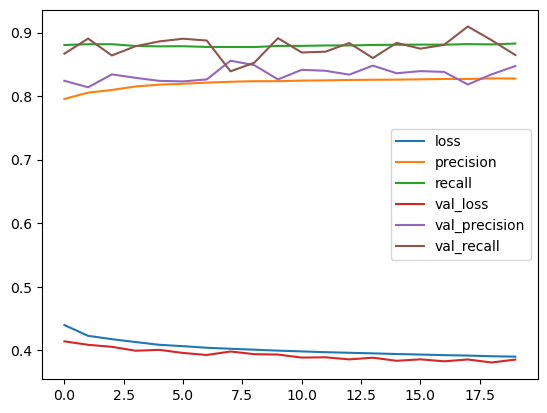

In [32]:
#Loss and Metric visualization
pd.DataFrame(model.history.history).plot()

48750/48750 [==============================] - 61s 1ms/step
F1 score for training: 85.2%


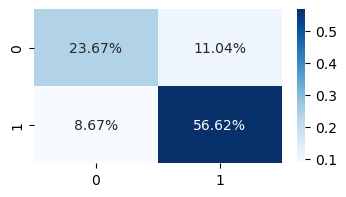

In [33]:
#Training predictions
train_prediction = model.predict(X_train_seq)
train_prediction = np.where(train_prediction.ravel()>0.5,1,0)

from sklearn.metrics import classification_report,confusion_matrix

#Training Confusion Matrix
train_confusion_matrix = confusion_matrix(list(y_train_seq),train_prediction)

import seaborn as sns
import matplotlib.pyplot as plt

#Confusion Matrix plot
plt.figure(figsize = (4,2))
sns.heatmap(train_confusion_matrix/np.sum(train_confusion_matrix), annot=True, fmt='.2%', cmap='Blues')

from sklearn.metrics import f1_score
print(f'F1 score for training: {round(f1_score(list(y_train_seq),train_prediction),3)*100}%')

11875/11875 [==============================] - 15s 1ms/step
F1 score for Validation: 85.6%


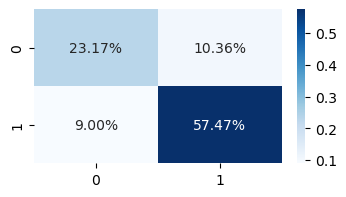

In [34]:
#Validation predictions
val_prediction = model.predict(X_val_seq)
val_prediction = np.where(val_prediction.ravel()>0.5,1,0)

#Validation Confusion Matrix
val_confusion_matrix = confusion_matrix(list(y_val_seq),val_prediction)

#Confusion Matrix plot
plt.figure(figsize = (4,2))
sns.heatmap(val_confusion_matrix/np.sum(val_confusion_matrix), annot=True, fmt='.2%', cmap='Blues')

print(f'F1 score for Validation: {round(f1_score(list(y_val_seq),val_prediction),3)*100}%')

625/625 [==============================] - 1s 1ms/step
F1 score for Test: 85.8%


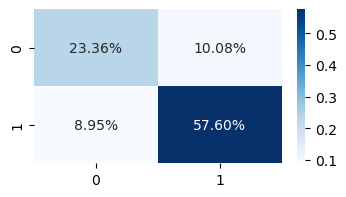

In [35]:
#Testing predictions
test_prediction = model.predict(X_test_seq)
test_prediction = np.where(test_prediction>0.5,1,0)

#Testing Confusion Matrix
test_confusion_matrix = confusion_matrix(list(y_test),test_prediction)

#Confusion Matrix plot
plt.figure(figsize = (4,2))
sns.heatmap(test_confusion_matrix/np.sum(test_confusion_matrix), annot=True, fmt='.2%', cmap='Blues')

print(f'F1 score for Test: {round(f1_score(list(y_test),test_prediction),3)*100}%')

### Conclusion

An acceptable model has been found to predict if each student will pass the following question using recurrent neural networks (LSTM), considering the times t-2, t-1 and t to predict time t. Both in the training, validation and testing base, the F1 metric yields similar values, around 86%. It has started with a dataset made up of 32 columns (mostly string columns) to end up with 148 columns, after data preprocessing, feature engineering and data imputation.